# Imports

In [40]:

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
import data_func.read_data as read_data
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")



# Load datasets

In [41]:
import data_func.read_data as read_data

dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()


In [42]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]


In [43]:
print(len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 00:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))


136245
Index([118664], dtype='int64')
136244


# Data clean up

[]
[635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 707, 708, 709, 710, 711, 712, 713, 1348, 1349, 1350, 1351, 1352, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256,

<Axes: title={'center': 'Target C Clean'}, xlabel='time'>

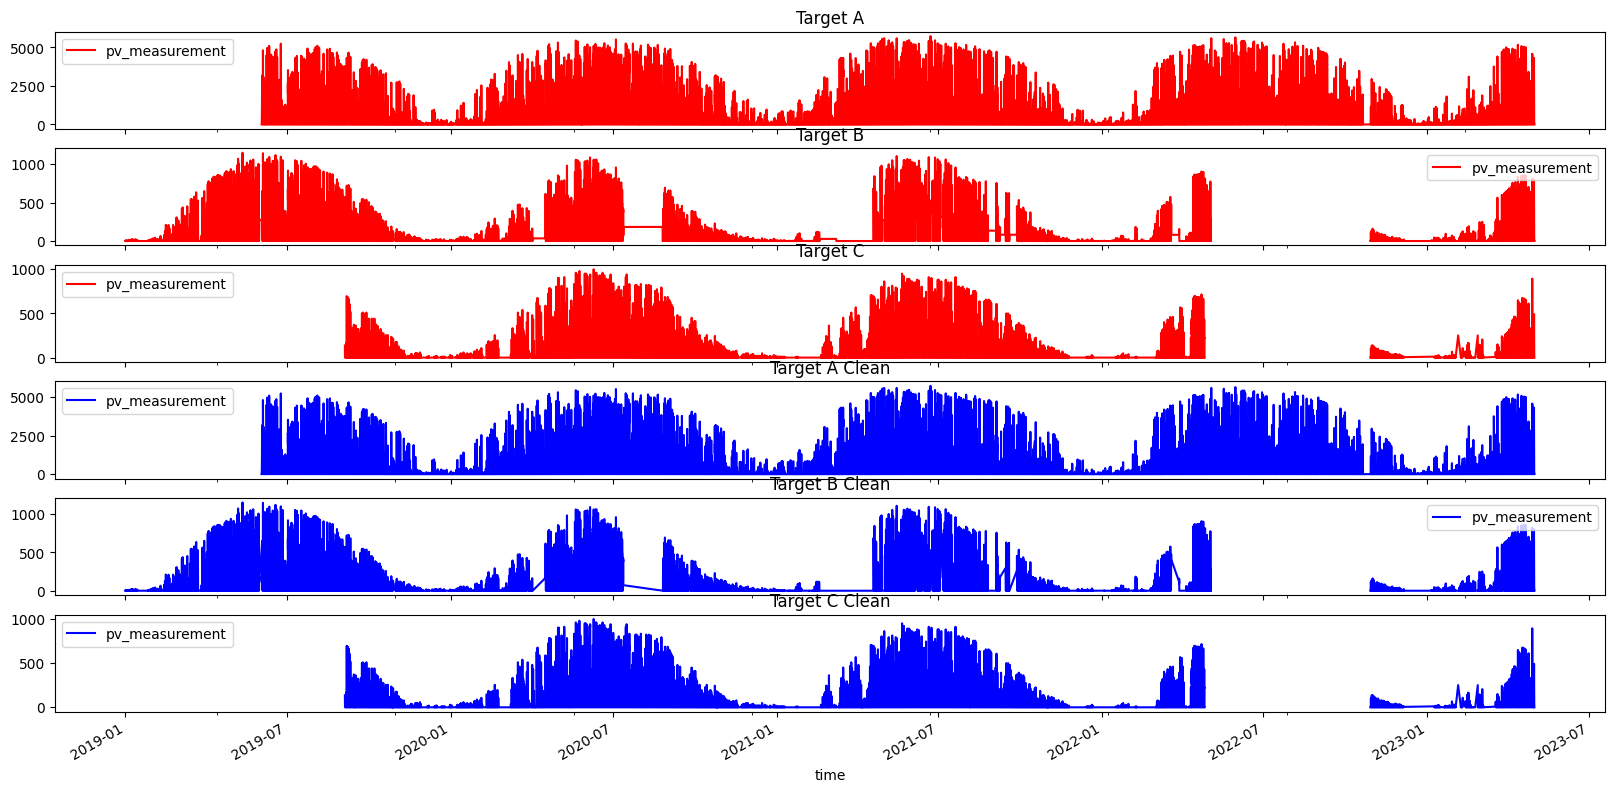

In [44]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



# Data Aggregation

In [45]:
# making shure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median, merge_on = 'first')
   mean = data_agg.gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])


In [46]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))


x,y:  34060 34060
x,y:  25996 25996
x,y:  23099 23099


In [47]:
X_train[0].tail()


,date_forecast,dew_or_rime:idx,precip_type_5min:idx,is_day:idx,is_in_shadow:idx,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
34055,2023-04-30 19:00:00,0,0,0,1,4.55,1.27650,1674.199951,84464.945312,4.225,...,304.939240,-0.18050,0.000,275.024994,96.699997,23417.074219,5.175,4.800,1.925,0.0
34056,2023-04-30 20:00:00,0,0,0,1,4.50,1.27975,1762.400024,2270.875000,0.000,...,318.625763,-5.17600,0.000,274.650024,94.525002,21084.050781,4.650,4.025,2.300,0.0
34057,2023-04-30 21:00:00,0,0,0,1,4.50,1.28100,1696.650024,0.000000,0.000,...,332.785736,-8.95075,0.000,274.524994,95.675003,20792.500000,4.450,3.575,2.600,0.0
34058,2023-04-30 22:00:00,0,0,0,1,4.50,1.28100,1353.400024,0.000000,0.000,...,347.377991,-11.23325,0.100,274.325012,98.875000,14158.099609,4.100,3.175,2.550,0.0
34059,2023-04-30 23:00:00,0,0,0,1,4.50,1.28100,1626.574951,0.000000,0.000,...,92.209503,-11.84150,0.075,274.225006,99.699997,11872.299805,3.750,2.725,2.550,0.0


# Feature engineering

In [48]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
import data_func.date_forecast as DF
for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    X_train[i] = DF.date_forecast_columns(X_train[i])

for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    X_frames_test[i] = DF.date_forecast_columns(X_frames_test[i])    
 

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
    temp = pd.concat([train, test], ignore_index=True)
    index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
    return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
     X_train[i] = OHE.one_hot_encode(X_train[i],OH_columns)
     X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], OH_columns)
     X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
     X_train[i].drop(columns=['date_forecast'], inplace=True)
     X_frames_test[i].drop(columns=['date_forecast'], inplace=True)


# Data cleaning

In [49]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,6126,3609,4342
cloud_base_agl:m,2362,1367,1686
snow_density:kgm3,32920,24141,21686


In [50]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
snow_density:kgm3,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720
precip_type_5min:idx_5,720,720,720


In [51]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 20000, "cloud_base_agl:m": 20000}

for i in range(len(X_train)):
    X_train[i].drop(columns=['snow_density:kgm3', 'elevation:m', 'year'], inplace=True)
    X_frames_test[i].drop(columns=['snow_density:kgm3', 'elevation:m', 'year'], inplace=True)
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)




In [52]:
# Split the data into training and validation sets

x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(X_train[0], Y_train[0], test_size=0.17, random_state=69)
x_train_b, x_val_b, y_train_b, y_val_b = train_test_split(X_train[1], Y_train[1], test_size=0.17, random_state=69)
x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(X_train[2], Y_train[2], test_size=0.17, random_state=69)


# Training the model

In [53]:



# Use params from hyperparameter tuning using optuna
params_a = {'random_state': 42, 'learning_rate': 0.039975576144155645, 'depth': 9, 'subsample': 0.4504678933801176, 'colsample_bylevel': 0.9773225861097778, 'min_data_in_leaf': 90}
params_b = {'random_state': 42, 'learning_rate': 0.023765834908014156, 'depth': 10, 'subsample': 0.8298593330195755, 'colsample_bylevel': 0.6060393047650714, 'min_data_in_leaf': 61}
params_c = {'random_state': 42, 'learning_rate': 0.060183973978509046, 'depth': 10, 'subsample': 0.28819995411353627, 'colsample_bylevel': 0.39818319507473743, 'min_data_in_leaf': 77}

# Hypertuned params, but worse :(
# params_a = {'random_state': 42, 'learning_rate': 0.09566223811599815, 'depth': 7, 'subsample': 0.960801961471582, 'colsample_bylevel': 0.6043383106745279, 'min_data_in_leaf': 78}
# params_b = {'random_state': 42, 'learning_rate': 0.04250298579274471, 'depth': 10, 'subsample': 0.5902141253689043, 'colsample_bylevel': 0.4702544263427683, 'min_data_in_leaf': 87}
# params_c = {'random_state': 42, 'learning_rate': 0.008810167623455675, 'depth': 10, 'subsample': 0.8621321557173095, 'colsample_bylevel': 0.6774949043850594, 'min_data_in_leaf': 25}

model_a = CatBoostRegressor(**params_a)
model_b = CatBoostRegressor(**params_b)
model_c = CatBoostRegressor(**params_c)


model_a.fit(x_train_a, y_train_a)
model_b.fit(x_train_b, y_train_b)
model_c.fit(x_train_c, y_train_c)


0:	learn: 1135.5284793	total: 42ms	remaining: 42s
1:	learn: 1099.4447799	total: 73.4ms	remaining: 36.6s
2:	learn: 1065.2001107	total: 106ms	remaining: 35.1s
3:	learn: 1033.1194092	total: 133ms	remaining: 33s
4:	learn: 1002.2814227	total: 164ms	remaining: 32.7s
5:	learn: 972.3827654	total: 212ms	remaining: 35.1s
6:	learn: 944.2374268	total: 238ms	remaining: 33.8s
7:	learn: 916.9383139	total: 274ms	remaining: 34s
8:	learn: 891.0716215	total: 325ms	remaining: 35.8s
9:	learn: 866.8248540	total: 379ms	remaining: 37.5s
10:	learn: 843.1127410	total: 412ms	remaining: 37s
11:	learn: 821.3069355	total: 442ms	remaining: 36.4s
12:	learn: 800.2916961	total: 495ms	remaining: 37.6s
13:	learn: 780.0156411	total: 522ms	remaining: 36.8s
14:	learn: 760.7930491	total: 547ms	remaining: 35.9s
15:	learn: 742.6202652	total: 574ms	remaining: 35.3s
16:	learn: 725.3218268	total: 601ms	remaining: 34.7s
17:	learn: 708.4446316	total: 644ms	remaining: 35.1s
18:	learn: 692.8565955	total: 712ms	remaining: 36.7s
19:	le

# Evaluate prediction

In [54]:
# Evaluate the model based on the validation data

mse_a = mean_squared_error(y_val_a, model_a.predict(x_val_a))
print("MSE for A: ", mse_a)
mse_b = mean_squared_error(y_val_b, model_b.predict(x_val_b))
print("MSE for B: ", mse_b)
mse_c = mean_squared_error(y_val_c, model_c.predict(x_val_c))
print("MSE for C: ", mse_c)
print("Mean MSE: ", (mse_a + mse_b + mse_c) / 3)

# Evaluate the predictions

score_a = model_a.score(x_val_a, y_val_a)
score_b = model_b.score(x_val_b, y_val_b)
score_c = model_c.score(x_val_c, y_val_c)

print("Score A: ", score_a)
print("Score B: ", score_b)
print("Score C: ", score_c)
print('')

# Mean MSE:  42084.56540106134


MSE for A:  127691.26542430313
MSE for B:  3442.0027490801967
MSE for C:  2363.4428896704844
Mean MSE:  44498.9036876846
Score A:  0.9000707670339375
Score B:  0.9191450661603592
Score C:  0.9215477672655417



In [55]:
mae_a = mean_absolute_error(y_val_a, model_a.predict(x_val_a))
print("MAE for A: ", mae_a)
mae_b = mean_absolute_error(y_val_b, model_b.predict(x_val_b))
print("MAE for B: ", mae_b)
mae_c = mean_absolute_error(y_val_c, model_c.predict(x_val_c))
print("MAE for C: ", mae_c)
print('total MAE: ', (mae_a + mae_b + mae_c))

# MAE for A:  162.5266393910826
# MAE for B:  23.919719695561408
# MAE for C:  18.163366570331068
# total MAE:  204.6097256569751


MAE for A:  164.91014219429033
MAE for B:  24.87513426080506
MAE for C:  19.11467115598575
total MAE:  208.89994761108113


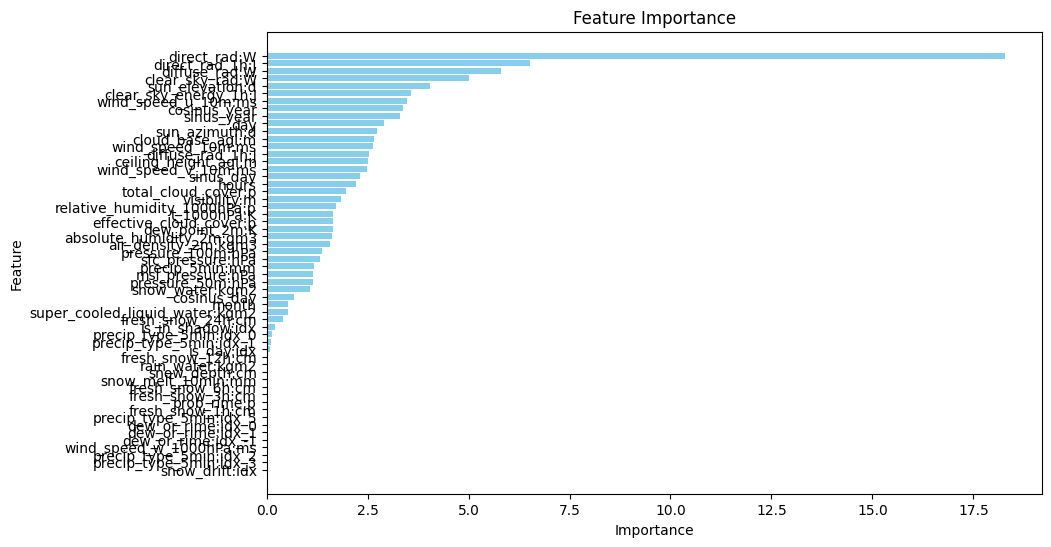

In [56]:
import matplotlib.pyplot as plt

feature_importance = model_a.get_feature_importance()
# Create a DataFrame to store feature names and their importance scores
importance_df = pd.DataFrame({'Feature': x_train_a.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance scores in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot to visualize feature importance

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
plt.show()


# Make predictions

In [57]:

# Train the model on the entire training data
model_a.fit(X_train[0], Y_train[0])
model_b.fit(X_train[1], Y_train[1])
model_c.fit(X_train[2], Y_train[2])

y_pred_a = model_a.predict(X_frames_test[0])
y_pred_b = model_b.predict(X_frames_test[1])
y_pred_c = model_c.predict(X_frames_test[2])
print(len(y_pred_a))

y_pred = np.concatenate((y_pred_a, y_pred_b, y_pred_c), axis=0)



0:	learn: 1128.6166949	total: 46.7ms	remaining: 46.6s
1:	learn: 1092.8932440	total: 79.1ms	remaining: 39.5s
2:	learn: 1059.1131517	total: 113ms	remaining: 37.5s
3:	learn: 1026.3682334	total: 146ms	remaining: 36.3s
4:	learn: 995.6995260	total: 185ms	remaining: 36.7s
5:	learn: 965.8079268	total: 247ms	remaining: 41s
6:	learn: 937.7051502	total: 282ms	remaining: 40s
7:	learn: 910.9107658	total: 330ms	remaining: 40.9s
8:	learn: 885.4276838	total: 403ms	remaining: 44.4s
9:	learn: 861.2275497	total: 429ms	remaining: 42.5s
10:	learn: 837.8839607	total: 454ms	remaining: 40.8s
11:	learn: 815.6232302	total: 490ms	remaining: 40.3s
12:	learn: 794.7325080	total: 544ms	remaining: 41.3s
13:	learn: 774.6346623	total: 570ms	remaining: 40.2s
14:	learn: 755.7333355	total: 597ms	remaining: 39.2s
15:	learn: 737.6853496	total: 624ms	remaining: 38.4s
16:	learn: 720.3802822	total: 656ms	remaining: 38s
17:	learn: 703.6617148	total: 701ms	remaining: 38.3s
18:	learn: 688.4204027	total: 768ms	remaining: 39.6s
19:

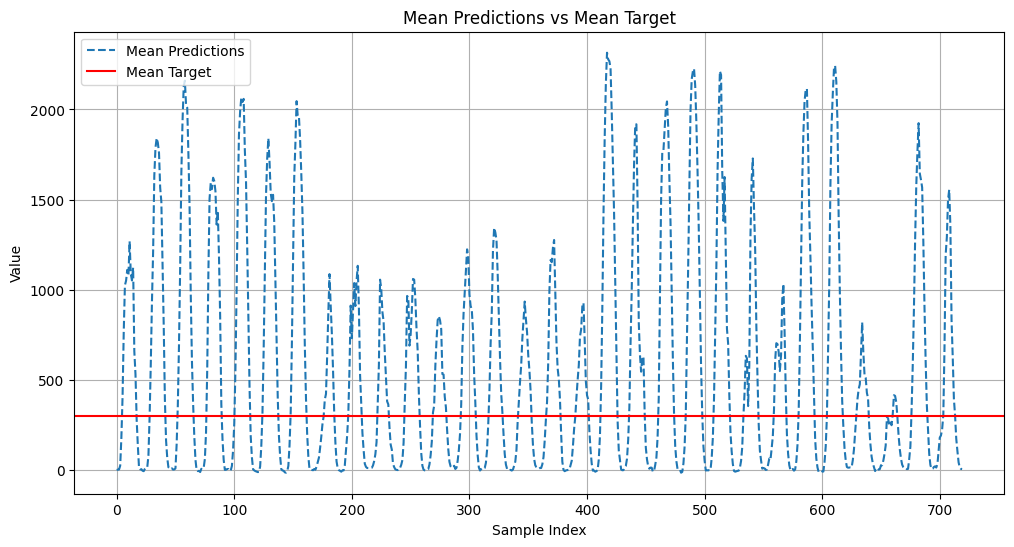

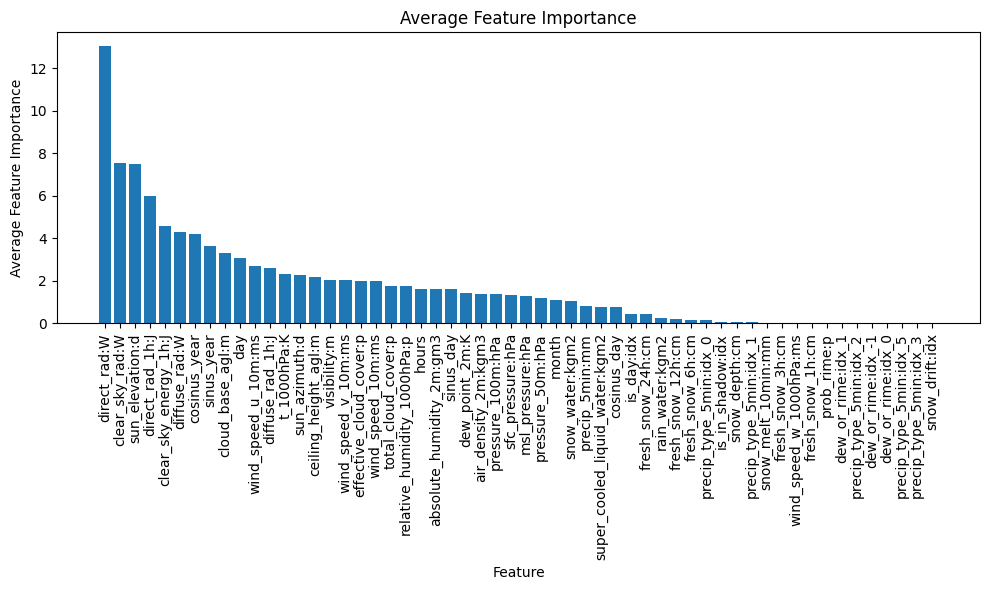

In [65]:
# Concatenate the individual target arrays
y_val_combined = np.concatenate([y_val_a, y_val_b, y_val_c])

# Compute mean predictions
mean_predictions = np.mean([y_pred_a, y_pred_b, y_pred_c], axis=0)
mean_target = np.mean(y_val_combined)

# Average predictions for the features
avg_feature_importance = (model_a.get_feature_importance() + model_b.get_feature_importance() + model_c.get_feature_importance()) / 3

# Create the feature importance chart
sorted_idx = avg_feature_importance.argsort()[::-1]
feature_names = x_train_a.columns  # Assuming your data is in a DataFrame
sorted_feature_names = [feature_names[i] for i in sorted_idx]

# Plot the mean predictions and mean target
plt.figure(figsize=(12, 6))
plt.plot(mean_predictions, label='Mean Predictions', linestyle='--')
plt.axhline(y=mean_target, color='red', label='Mean Target', linestyle='-')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Mean Predictions vs Mean Target')
plt.legend()
plt.grid()

# Create the feature importance chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(avg_feature_importance)), avg_feature_importance[sorted_idx])
plt.xticks(range(len(avg_feature_importance)), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance')
plt.tight_layout()

plt.show()

In [59]:
print(len(y_pred_a), len(X_frames_test[0]))
print(len(y_pred_b), len(X_frames_test[1]))
print(len(y_pred_c), len(X_frames_test[2]))


720 720
720 720
720 720


In [60]:
for i in range(len(y_pred)):
    if y_pred[i] < 0: 
        y_pred[i] = 0



# Create submission

In [61]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/submission_cat.csv', index=False)


FileNotFoundError: [Errno 2] No such file or directory: '../data/test.csv'